In [1]:
from sklearn.manifold import TSNE #문서 분포를 보여주기 위한 차원 축소 패키지
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)
    

## Crawler

Cralwer는 웹문서 수집 단계를 수행하는 역할을 한다. Crawler를 사용한다면 입력된 URL을 사용하여 모든 관련 웹문서들을 모두 수집을 하며 앞으로 사용자들은 이 웹문서를 기반으로 하여 원하는 작업을 수행할 수 있다. 그렇다면 이러한 Crawler를 직접 구현해 보도록 하겠다. 이를 위해 필요한 패키지들을 미리 확인해 보도록 하겠다.

### Requeats

![](./images/requests.png)

가장 첫번째 단계인 웹문서 수집을 위하여서는 URL과 더불어서 이를 Python상에 불러올 수 있는 Requests 패키지를 필요로 한다. Requests 패키지는 Anaconda을 사용하고 있다면 기본적으로 설치되어 있는 패키지이다.

### BeautifulSoup

BeautifulSoup 은 requests 패키지를 사용하여 읽어온 웹문서들을 태그와 Class, id를 기반으로 하여 목적으로 하는 내용을 분류할 수 있는 패키지이다. 많은 웹문서들은 HTML 태그에 Class와 ID를 적용하여 구분을 하곤 한다.

![](./images/news.png)

다양한 태그들 안에 class값들이 구분되어 있다. 동일한 클래스를 사용하는 경우도 있고, 독립적인 클래스를 사용하는 경우도 있다. 따라서 단순히 태그로만 구분을 한다면 수없이 많은 데이터들을 얻게 되어 작업이 매우 복잡하고 오래걸릴 것이다. BeautifulSoup을 사용한다면 태그 뿐만 아니라 Calss와 ID를 통하여 목적에 맞는 데이터를 쉽게 얻을 수 있다.

![](./pic/tag.png)

### URLparse

URLparse 패키지는 URL을 분석하여 URL에 담겨있는 속성들을 찾고 이들을 나누어 따로 저장하여 둔다. URL이 실행하고자 하는 명령과 설정값들을 모두 한번에 저장해 두고 있으며 이를 기존의 Split 함수를 사용하여 나눌 수 있으나 이를 보다 빠르고 편하게 지원하는 패키지이다.

## Crawler 만들기

In [3]:
from bs4 import BeautifulSoup
#import urllib.request             # HTTP Request and Response
#from urllib.parse import quote    # UTF-8 to ASCII for URL
from urllib.parse import urlparse, parse_qs # URL Parsing
import requests
import re

Naver사의 뉴스중 "가장 많이 본 뉴스" 부분을 사용

![](./images/crawl1.png)

이 부분에 해당된다. 뉴스 기사는 매일 갱신되는 관계로 수집하는 웹문서의 내용은 매일 달라진다.

해당 주소를 사용하기 위하여 Naver의 URL을 가져온다.

In [4]:
#-*- coding: utf-8 -*-
NEWS_PATH = "./news/"
NAVER_NEWSNOW_URL = "http://news.naver.com"

In [5]:
def get_news_list():
    newslist_html = requests.get(url=NAVER_NEWSNOW_URL).content
    newslist_lxml = BeautifulSoup(newslist_html, 'lxml', from_encoding='utf-8')
    newslist = [i.get('href') for i in newslist_lxml.select('ul.type14 li a.sm2')]
    print(newslist)
    return newslist

Requests 패키지의 get 함수를 사용하면 URL이 가리키는 웹문서를 그대로 가져온다. 그렇지만 뒤에 content를 붙였다는 것처럼, 그냥 get함수만 사용한다고 해서 내용을 수집할 수 있는 것은 아니다. 이는 requests 패키지 안에서 정의된 Object를 반환하기 때문이다. 여기서 이제 웹문서 안의 내용을 가져와야 한다. 이를 위해 get 함수에는 content attribute가 존재한다. 이는 get함수를 통해 받은 Object에서 content를 반환하는 attribute이며 이를 사용하여 웹문서 내용을 가져왔다. 해당 코드를 실행하면 결과가 출력될 것이다.

In [6]:
get_news_list()

['/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=001&aid=0009788566&date=20180103&type=1&rankingSeq=1&rankingSectionId=100', '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=020&aid=0003119085&date=20180103&type=1&rankingSeq=1&rankingSectionId=101', '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=025&aid=0002786697&date=20180103&type=1&rankingSeq=1&rankingSectionId=102', '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=025&aid=0002786756&date=20180103&type=1&rankingSeq=1&rankingSectionId=104', '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=213&aid=0001009891&date=20180103&type=1&rankingSeq=1&rankingSectionId=106']


['/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=001&aid=0009788566&date=20180103&type=1&rankingSeq=1&rankingSectionId=100',
 '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=020&aid=0003119085&date=20180103&type=1&rankingSeq=1&rankingSectionId=101',
 '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=025&aid=0002786697&date=20180103&type=1&rankingSeq=1&rankingSectionId=102',
 '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=025&aid=0002786756&date=20180103&type=1&rankingSeq=1&rankingSectionId=104',
 '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=213&aid=0001009891&date=20180103&type=1&rankingSeq=1&rankingSectionId=106']

In [7]:
print(requests.get(url=NAVER_NEWSNOW_URL).content)

b'<!DOCTYPE HTML>\n<html lang="ko">\n<head>\n<meta charset="euc-kr">\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta http-equiv="refresh" content="600" />\n<meta name="viewport" content="width=1023" />\n\r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n    \r\n\r\n<meta property="og:title"       content="\xb3\xd7\xc0\xcc\xb9\xf6 \xb4\xba\xbd\xba">\r\n<meta property="og:type"        content="website">\r\n<meta property="og:url"         content="http://news.naver.com/main/home.nhn">\r\n<meta property="og:image"       content="http://static.news.naver.net/image/news/ogtag/navernews_200x200_20160804.png"/>\r\n<meta property="og:description" content="\xc1\xa4\xc4\xa1, \xb0\xe6\xc1\xa6, \xbb\xe7\xc8\xb8, \xbb\xfd\xc8\xb0/\xb9\xae\xc8\xad, \xbc\xbc\xb0\xe8, IT/\xb0\xfa\xc7\xd0 \xb5\xee \xbe\xf0\xb7\xd0\xbb\xe7\xba\xb0, \xba\xd0\xbe\xdf\xba\xb0 \xb4\xba\xbd\xba \xb1\xe2\xbb\xe7 \xc1\xa6\xb0\xf8">\r\

 이제 여기서BeautifulSoup 패키지를 사용하여 가져온 웹문서를 lxml형식으로 우리가 원하는 내용만을 따로 뽑아서 저장한다. 가져오는 절차는 다음과 같다.

* 변환된 웹문서에서 ul태그의 Class가 'type14' 인 태그를 확인하고 그 안의 li 태그를 확인한다.
* 내부 a 태그 중 Class가 'sm2'인 태그를 찾아 그 안에 있는 내용을 모두 가져온다.
* 마지막으로 'href'가 있는 태그의 내용을 가져와 저장을 한다. 이를 통해 웹문서 안에 있는 "가장 많이 본 뉴스"의 url주소를 얻는다.

 이번에는 얻어낸 URL을 통하여 해당 기사 웹문서 안에 우리가 필요한 부분인 제목과 기사본문만을 가져와 저장하도록 한다. 이를 위해 새로운 함수 get_news_content를 만든다.

In [8]:
def get_news_content(news_url): 
    news_id = ''
    newscontent_text = ''
    url_params = urlparse(news_url)
    url_params = parse_qs(url_params.query)
    news_id = url_params['aid']
    #print(news_id)
    newscontent_html = requests.get(NAVER_NEWSNOW_URL + news_url).content
    newscontent_lxml = BeautifulSoup(newscontent_html, 'lxml', from_encoding='utf-8')
    
    newscontent_head = newscontent_lxml.select('#articleTitle')
    newscontent_list = newscontent_lxml.select('#articleBodyContents')
    
    if not newscontent_head:
        newscontent_head = newscontent_lxml.select('.end_tit')
    if not newscontent_list:
        newscontent_list = newscontent_lxml.select('#articeBody')
    
    newscontent_text += str(newscontent_head[0].find_all(text=True))
    newscontent_text += str(newscontent_list[0].find_all(text=True))
    
    save_file(NEWS_PATH + str(news_id[0]) + '.txt', newscontent_text)

URLparse 패키지를 사용하여 URL을 값에 따라 분리하였고, 여기서 Naver사의 "가장 많이 본 뉴스" 부분은 'aid'라는 값을 지니고 있기 때문에 해당 "aid"값을 news의 id로 파악하여 저장해 두었다. 저장한 id는 앞으로 우리가 수집한 기사 제목과 내용을 저장할 파일 이름으로 설정한다. 앞서 보았던 것 과 같은 방식으로 이번에는 기사 웹문서의 URL을 requests와 BeautifulSoup을 사용하여 내용을 가져오고, if문을 사용하여 태그 안에 id가 'articleTitle'인 경우 이는 제목이기 때문에 저장을 하고, 'articleBodyContents'인 경우에는 기사 본문이기 때문에 기사 본문을 가져와 저장한다. 각각은 newscontent_text라는 변수에 지속적으로 추가되어 모여져 있다. 마지막으로 save_file 함수를 사용하여 모아온 newscontent_text 변수를 파일에 입력하여 저장함으로 써 aid값을 지닌 news_id를 파일의 이름으로, newscontent_text를 내용으로 하여 저장을 진행한다.

In [9]:
def save_file(filename, text):
    news_file = open(filename, 'w', encoding='utf-8')
    news_file.write(text)
    news_file.close()

In [10]:
def open_file(file):
    news_file = open(file, 'r', encoding='utf-8')
    content = news_file.read()
    news_file.close()
    return content

이제 실제로 url을 긁어오는 작업을 진행해 주어야 한다. news_list라는 변수에 앞서 만든 "가장 많이 본 뉴스" 목록을 읽어 기사들의 URL을 저장시키고 그 URL들을 한개씩 get_news_content 함수에 입력값으로 넣어서 제목과 본문을 news_id의 이름을 가진 파일로 저장하였다.

In [11]:
news_list = get_news_list()
for news_url in news_list:
    get_news_content(news_url)

['/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=001&aid=0009788566&date=20180103&type=1&rankingSeq=1&rankingSectionId=100', '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=020&aid=0003119085&date=20180103&type=1&rankingSeq=1&rankingSectionId=101', '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=025&aid=0002786697&date=20180103&type=1&rankingSeq=1&rankingSectionId=102', '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=025&aid=0002786756&date=20180103&type=1&rankingSeq=1&rankingSectionId=104', '/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=213&aid=0001009891&date=20180103&type=1&rankingSeq=1&rankingSectionId=106']


## KoNLPy

![](http://konlpy-ko.readthedocs.io/ko/v0.4.3/_static/konlpy.png)

In [12]:
from konlpy.tag import Kkma
from konlpy.utils import pprint
from collections import Counter
import os
import re
import math
import pickle
import operator

## 데이터전처리
lxml 형식으로 가져온 데이터는 html 코드로 작성되어있다. html 코드에서의 줄바꿈이나 4칸 뛰우는 기능은 \n, \t와 같은 코드들로 이루어져 있고 텍스트 데이터를 처리할 때 불필요한 존재들이다. 뉴스에서 가져온 말뭉치 데이터에서 불필요한 html 용어들이나 스크립트 코드들을 가능한 없애야 워드임베딩에서 좋은 결과를 얻을 수 있다.

In [13]:
def preprocessing(content):
    #content = re.sub('[a-zA-Z]', '', content)
    content = re.sub('\\xa0', '', content)
    content = re.sub('\\n', '', content)
    content = re.sub('\\\\xa0', '', content)
    content = re.sub('\\\\n', '', content)
    content = re.sub('[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\")]', '', content)
    content = ' '.join(content.split())
    
    return content

# 토크나이징 : word2vec 입력값의 단위를 정한다.

prhase는 어절 단위로 끊는 방법으로 제일 간단하고 쉽게 구현이 가능하지만 단어의 빈도를 잘 측정하지 못한다. 아빠의 빈도를 알고 싶지만 문서 내에서는 아빠가, 아빠는, 아빠에게 와 같은 명사 + 조사 같은 형식을 하나로 받기 때문에 다른 단어로 취급해서 단어빈도를 구하기 힘들다.

ngram은 음절 단위로 끊는 방법으로 주로 2~3 음절로 끊어서 사용한다. 본문 텍스트에 그대로 적용하면 공백이나 "와 같은 기호들도 포함해서 짤라서 단어의 빈도는 알 수 있으나 불필요한 데이터도 많이 만든다는 단점이 있다.

noun은 명사만 뽑는 방법으로 KonPLy에서 만든 한국어 정보처리 패키지를 사용해서 어절단위로 끊으면서 단어를 분석해 준다. 명사의 가능성이 조금이라도 있으면 선택하기 때문에 각종 신조어나 등장하지 않았던 단어들까지 명사로 보고 선택한다.

morpheme은 KonPLy에서 만든 형태소 분석기를 사용해서 형태소에 품사를 태그하여 어떠한 형태소가 어떤 품사인지에 분석한다. 명사이면 NNG와 같은 명사, 동사에는 VV와 같은 단어 등이 태그된다. 이에 대한 정보는 KoNLPy에서 보다 자세히 찾아볼 수 있다. 아래의 사진에서 간단한 예를 확인할 수 있다.

![](./images/konlpy.png)

In [14]:
def tokenizing(tool, content): #입력 문장 리스트를 토크나이징한다.
    kkma = Kkma()
    featurelist = []
    if tool == 'phrase':        
        for term in content.split():
            featurelist.append(term)
    elif tool == 'noun':
        for phrase in content.split():
            for term in kkma.nouns(phrase):
                featurelist.append(term)
    elif tool == 'morpheme':
        for term in kkma.pos(content):
            term = term[0] + '/' + term[1]
            featurelist.append(term)
    else:
        return False
    
    return featurelist

In [15]:
def get_filelist(path): #디렉토리 내의 파일 위치를 리스트로 반환.
    filelist = []
    for (path, dir, files) in os.walk(NEWS_PATH):
        for file in files:
            ext = os.path.splitext(file)[-1]
            
            if ext == '.txt':
                filelist.append("%s%s" % (path, file))          
    return filelist

In [17]:
filelist = get_filelist(NEWS_PATH)
termlists = []
for file in filelist:
    filename = os.path.basename(file)
    #pprint(filename)
    content = preprocessing(open_file(file))
    #content = open_file(file)
    #termlist = content
    termlist = tokenizing('noun', content)
    termlists.append(termlist)
pprint(termlists)

[['뉴스',
  '스마트',
  '스마트폰',
  '폰',
  '자아',
  '자아도취',
  '도취',
  '셀',
  '셀카',
  '카',
  '남성',
  '덜미',
  '공개',
  '공개수배',
  '수배',
  '본문',
  '내용',
  '플레이어',
  '플레이어',
  '오류',
  '우회',
  '위',
  '함수',
  '추가',
  '한',
  '남성',
  '스마트',
  '스마트폰',
  '폰',
  '셀',
  '셀카',
  '카',
  '덜미',
  '현지',
  '시간',
  '그제',
  '그제10일',
  '10',
  '일',
  '영국',
  '데일리',
  '데일리메일',
  '메일',
  '등',
  '외신',
  '결정적',
  '단서',
  '제공',
  '남성',
  '보도',
  '지난달',
  '말',
  '영국',
  '솔',
  '셜',
  '셜리',
  '리',
  '지역',
  '59',
  '59살',
  '살',
  '여성',
  '스마트',
  '스마트폰',
  '폰',
  '차',
  '스마트',
  '스마트폰',
  '폰',
  '두고',
  '일',
  '간',
  '사이',
  '여성',
  '경찰',
  '신고',
  '뒤',
  '발',
  '뜻밖',
  '사고',
  '다음',
  '날',
  '여성',
  '범인',
  '얼굴',
  '확인',
  '수',
  '범인',
  '얼굴',
  '선명',
  '사진',
  '여성',
  '인터넷',
  '웹',
  '웹하드',
  '하드',
  '여성',
  '평소',
  '스마트',
  '스마트폰',
  '폰',
  '사진',
  '인터넷',
  '저장',
  '스마트',
  '스마트폰',
  '폰',
  '인터넷',
  '웹',
  '웹하드',
  '하드',
  '연동',
  '이',
  '사실',
  '알',
  '범인',
  '스마트',
  '스마트폰',
  '폰',
  '셀',
  '셀카',
  '카',
  '놀이',
  '결국

  '논란',
  '다니엘',
  '김',
  '김사랑',
  '사랑',
  '등',
  '다양',
  '스타',
  '군단',
  '출연',
  '기회',
  '나',
  '혼자',
  '산다',
  '연출',
  '황지',
  '황지영',
  '영',
  '8',
  '8관왕',
  '관',
  '왕',
  '소감',
  '신년',
  '목표',
  '나',
  '혼자',
  '산다',
  '8',
  '8관왕',
  '관',
  '왕',
  '소감',
  '1',
  '1년간',
  '년',
  '간',
  '전',
  '제작진',
  '한',
  '마음',
  '거',
  '생각',
  '나',
  '혼자',
  '산다',
  '사랑',
  '주신',
  '시청자',
  '시청자분',
  '분',
  '덕분',
  '생각',
  '수상',
  '후',
  '말',
  '대상',
  '전',
  '전회장',
  '회장',
  '신인',
  '대배우',
  '눈치',
  '나중',
  '회식',
  '자리',
  '서로',
  '격려',
  '진심',
  '축하',
  '더',
  '중요',
  '시기',
  '부담감',
  '부담감',
  '게',
  '사실',
  '며칠',
  '밤',
  '고민',
  '제작진',
  '더',
  '욕심',
  '내서',
  '힘',
  '무리수',
  '결국',
  '프로그램',
  '독',
  '수',
  '생각',
  '대로',
  '각자',
  '자리',
  '최선',
  '촬영',
  '시청자',
  '시청자분',
  '분',
  '사랑',
  '주실',
  '거',
  '나',
  '혼자',
  '산다',
  '만',
  '저력',
  '무엇',
  '각자',
  '역할',
  '팀원',
  '덕분',
  '생각',
  '재기',
  '조연출',
  '편집',
  '일',
  '작가',
  '프로그램',
  '열정',
  '출연자',
  '이',
  '결과',
  '생각',
  '협업',
  '방송',
  

  '우회',
  '위',
  '함수',
  '추가',
  '서울',
  '서울뉴시스',
  '뉴',
  '시스',
  '박진',
  '여중생',
  '살해',
  '사체',
  '유기',
  '혐의',
  '구속',
  '어금니',
  '아빠',
  '재판',
  '17',
  '17일',
  '일',
  '오전',
  '서울',
  '도봉',
  '도봉구',
  '구',
  '서울',
  '서울북부지방법원',
  '북부',
  '지방',
  '법원',
  '20171117',
  '서울',
  '서울뉴시스',
  '뉴',
  '시스',
  '유자',
  '기자',
  '어금니',
  '아빠',
  '딸',
  '상습',
  '폭행',
  '의혹',
  '제기',
  '이',
  '이씨',
  '씨',
  '상습적',
  '폭행',
  '부인',
  '12',
  '12일',
  '일',
  '오전',
  '서울',
  '서울북부지법',
  '북부',
  '지법',
  '형사',
  '형사합의11부',
  '합의',
  '11',
  '부',
  '부장',
  '부장판사',
  '판사',
  '이성',
  '이성호',
  '호',
  '심리',
  '3',
  '3차',
  '차',
  '공판',
  '학',
  '성년자',
  '유인',
  '사체',
  '사체유기',
  '유기',
  '등',
  '혐의',
  '기소',
  '딸',
  '이모',
  '이모14양',
  '14',
  '양',
  '양형',
  '증인',
  '참석',
  '이날',
  '이양',
  '변호인',
  '이양',
  '물건',
  '뺨',
  '등',
  '상습적',
  '폭행',
  '추궁',
  '이',
  '이씨',
  '씨',
  '야단',
  '가방',
  '상습적',
  '폭행',
  '반박',
  '이양',
  '이',
  '이씨',
  '씨',
  '말',
  '저항',
  '질문',
  '이유',
  '개',
  '여섯',
  '여섯마리',
  '마리',
 

  '본문',
  '내용'],
 ['인터뷰',
  '태영',
  '평',
  '건',
  '예술단',
  '가능성',
  '본문',
  '내용',
  '플레이어',
  '플레이어',
  '오류',
  '우회',
  '위',
  '함수',
  '추가',
  '태영',
  '연합',
  '연합뉴스',
  '뉴스',
  '인터뷰',
  '인터뷰서울연합뉴스',
  '서울',
  '연합',
  '뉴스',
  '이',
  '이지은',
  '지은',
  '기자',
  '태영',
  '전',
  '영국',
  '주재',
  '북한',
  '2',
  '2일',
  '일',
  '오후',
  '서울',
  '강남',
  '강남구',
  '구',
  '국가',
  '국가안보전략연구원',
  '안보',
  '전략',
  '연구원',
  '연합',
  '연합뉴스',
  '뉴스',
  '인터뷰',
  '김',
  '대북',
  '대북제재',
  '제재',
  '공조',
  '각개',
  '각개격파',
  '격파',
  '깨',
  '의도',
  '비',
  '비사회주의',
  '사회',
  '주의',
  '현상',
  '투쟁',
  '중요시',
  '결집력',
  '문제',
  '방증',
  '김',
  '김여정',
  '여정',
  '한국',
  '건',
  '도박',
  '동생',
  '평',
  '도박',
  '연합',
  '연합뉴스',
  '뉴스',
  '인터뷰',
  '중인',
  '태영',
  '전',
  '공사',
  '공사서울연합뉴스',
  '서울',
  '연합',
  '뉴스',
  '이',
  '이지은',
  '지은',
  '기자',
  '태영',
  '전',
  '영국',
  '영국주재',
  '주재',
  '북한',
  '북한대사관',
  '대사관',
  '연합',
  '연합뉴스',
  '뉴스',
  '인터뷰',
  '201813',
  '끝',
  '서울',
  '서울연합뉴스',
  '연합',
  '뉴스',
  '지성',
  '기자',
  '태영',
  '전',

# DOC2VEC

In [22]:
import gensim
import smart_open

C:\Users\KBS\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [23]:
d2v_model = gensim.models.doc2vec.Doc2Vec(size=50, min_count=2, iter=55, dm=1, window=5) #learning rate #좀더알아보자

In [24]:
d2v_termlists = []
i = 0
for termlist in termlists:
    d2v_termlists.append(gensim.models.doc2vec.TaggedDocument(words = termlist, tags = ['DOCU_%d' % i]))
    i = i + 1

####Doc2vec은 입력을 TaggedDocument(words, tags)라는 클래스의 집합을 받기때문에 변환이 필요하다.
tags로 문서의 이름을 넣었어야 하지만, 그렇게 수행하지 못하였다. 추후에 수정해야한다.

In [53]:
d2v_termlists

[TaggedDocument(words=['뉴스', '스마트', '스마트폰', '폰', '자아', '자아도취', '도취', '셀', '셀카', '카', '남성', '덜미', '공개', '공개수배', '수배', '본문', '내용', '플레이어', '플레이어', '오류', '우회', '위', '함수', '추가', '한', '남성', '스마트', '스마트폰', '폰', '셀', '셀카', '카', '덜미', '현지', '시간', '그제', '그제10일', '10', '일', '영국', '데일리', '데일리메일', '메일', '등', '외신', '결정적', '단서', '제공', '남성', '보도', '지난달', '말', '영국', '솔', '셜', '셜리', '리', '지역', '59', '59살', '살', '여성', '스마트', '스마트폰', '폰', '차', '스마트', '스마트폰', '폰', '두고', '일', '간', '사이', '여성', '경찰', '신고', '뒤', '발', '뜻밖', '사고', '다음', '날', '여성', '범인', '얼굴', '확인', '수', '범인', '얼굴', '선명', '사진', '여성', '인터넷', '웹', '웹하드', '하드', '여성', '평소', '스마트', '스마트폰', '폰', '사진', '인터넷', '저장', '스마트', '스마트폰', '폰', '인터넷', '웹', '웹하드', '하드', '연동', '이', '사실', '알', '범인', '스마트', '스마트폰', '폰', '셀', '셀카', '카', '놀이', '결국', '공개', '수배', '대상', '범인', '아무것', '채', '익살', '표정', '다양', '각도', '장', '여성', '이', '남성', '스마트', '스마트폰', '폰', '간', '범인', '웨스트', '미들', '미들랜즈', '랜즈', '경찰서', '사진', '경찰', '측은', '공개', '수배', '수사', '중', '뉴스', '사진', '트위터', '조도', '조도혜', '혜

In [26]:
d2v_model.build_vocab(d2v_termlists) #모델에 단어를 빌드len(d2v_termlists)for epoch in range(10):

In [27]:
len(d2v_termlists)

10

In [28]:
for epoch in range(10):
    d2v_model.train(d2v_termlists,total_examples=d2v_model.corpus_count,epochs=d2v_model.iter)
    d2v_model.alpha -= 0.002 # decrease the learning rated2v_model.infer_vector(['in']) #입력 단어의 예측 벡터, 거의 0에서 머무른다.
    d2v_model.min_alpha = d2v_model.alpha # fix the learning rate, no deca
    d2v_model.train(d2v_termlists,total_examples=d2v_model.corpus_count,epochs=d2v_model.iter)

In [54]:
d2v_model['문재인']

array([ -1.13495612e+00,   1.29029441e+00,  -1.55901194e+00,
         2.77409720e+00,   8.62897754e-01,   7.48107672e-01,
         1.69270194e+00,  -3.57938766e-01,   2.60024381e+00,
        -4.48208563e-02,   7.74985075e-01,   6.68762326e-01,
         6.21350467e-01,  -3.00143808e-01,  -5.99341273e-01,
         9.58437264e-01,   2.97440529e+00,   1.23005295e+00,
         1.25967622e+00,  -1.68412519e+00,   1.38596320e+00,
         1.53660738e+00,  -6.20932519e-01,   5.52165926e-01,
        -5.25795758e-01,  -2.57715511e+00,   1.88290453e+00,
        -1.83978069e+00,  -2.68091869e+00,  -1.96554601e+00,
         1.06625056e+00,   1.20669043e+00,  -4.14464712e+00,
        -4.73583519e-01,   4.45888996e-01,  -3.31653804e-01,
        -2.43713212e+00,   1.95038450e+00,   1.40370757e-04,
         1.21784782e+00,   6.61466539e-01,  -1.03544343e+00,
        -1.69086695e+00,   1.23550546e+00,  -2.94060141e-01,
         1.15730798e+00,   6.97325051e-01,   1.79980648e+00,
         1.44163263e+00,

In [55]:
d2v_model.docvecs['DOCU_0']

array([-2.90614009,  2.6054244 , -4.31941271,  0.2847921 , -0.52279717,
       -1.33856606,  7.32744694,  0.2356202 ,  4.66836786,  0.07925382,
        2.66034317, -3.86461091, -1.71545601, -4.97805262, -0.29413775,
        1.04707944,  0.15077947,  3.0856986 ,  3.79126334, -0.26299989,
        0.15493308, -1.10034323, -3.18450832,  2.01621127, -3.76958919,
        2.8425498 ,  5.10713673, -8.13338852, -2.2842021 , -2.07409167,
        2.60022831,  8.88081169, -6.10870409,  0.91250396, -3.27111077,
       -2.82345414,  2.42132521,  3.26111436, -0.85295945,  0.44920054,
       -2.00193477, -4.84763479, -5.27031898,  4.08281708,  3.61347437,
        2.78080058, -0.03517248,  3.86827469, -1.86529684,  0.78123546], dtype=float32)

In [29]:
d2v_model.infer_vector(['in']) #입력 단어의 예측 벡터,영어에 대한 데이터가 없기때문에d2v_model.similar_by_word('무선망',topn=5000) 거의 0에서 머무른다.

array([  4.45908960e-03,  -6.06675807e-04,   5.76145481e-03,
         6.34445902e-03,  -6.79458678e-03,   9.41734295e-03,
         9.60948470e-04,  -5.19658206e-03,  -8.24061688e-03,
        -4.90160054e-03,   1.14363164e-03,  -9.11364704e-03,
         2.21830350e-03,   3.42713576e-03,  -3.42770061e-03,
        -9.50829126e-03,  -3.45165143e-03,  -7.95987342e-03,
         1.90223727e-05,  -4.40325076e-03,   7.03723286e-04,
         3.84801300e-03,   5.35454135e-03,  -7.43856560e-03,
         6.12672884e-03,  -9.16888006e-03,   8.81545618e-03,
        -3.66891176e-03,   5.71899256e-03,   5.24737127e-03,
         7.78872403e-04,   2.63627176e-03,  -5.14139514e-03,
        -7.16336537e-03,   5.19178389e-03,  -3.00519657e-03,
         9.71177965e-03,   1.19879151e-04,  -5.62672596e-03,
        -7.98126639e-05,  -4.24586749e-03,  -3.82552785e-03,
         7.05201412e-03,  -3.06204805e-04,  -1.02704717e-03,
         9.01798252e-03,  -3.07535334e-03,   6.10680087e-03,
        -5.97537309e-03,

In [30]:
d2v_model.similar_by_word('문재인',topn=5)

[('재인', 0.8507628440856934),
 ('문', 0.8168657422065735),
 ('주', 0.6675831079483032),
 ('촛불', 0.6673268675804138),
 ('인의', 0.6598222255706787)]

In [31]:
d2v_model.most_similar(positive=['문재인', '한미'], negative=['대통령'])

[('한미동맹', 0.7538739442825317),
 ('개월', 0.6868327856063843),
 ('건강', 0.657127320766449),
 ('주', 0.6525209546089172),
 ('다', 0.6290321946144104),
 ('이후', 0.6259393692016602),
 ('6개월', 0.6076993346214294),
 ('문', 0.6061509847640991),
 ('경제', 0.599109947681427),
 ('셜', 0.5975086092948914)]

In [32]:
import os
import numpy as np

In [33]:
ospath = './save'
if not os.path.exists(ospath):
    os.mkdir(ospath)
    
d2v_model.save('./save/model') #모델 저장하기

In [34]:
def random_embedding(dim):
    return np.random.uniform(-1,1,size=dim)

In [35]:
embedding_docs = []
for sentence in termlists: 
    embedding_sentence = []
    for word in sentence:
        try:
            embedding_sentence.append(d2v_model[word])
        except KeyError:
            embedding_sentence.append(random_embedding(50))
    embedding_sentence = np.asarray(embedding_sentence)
    embedding_docs.append(embedding_sentence)

In [36]:
embedding_docs = np.asanyarray(embedding_docs)

In [37]:
embedding_weights =d2v_model.wv.syn0
labels = d2v_model.wv.index2word

In [38]:
from matplotlib import font_manager, rc #TSNE 그림에서 한글이 깨지는 문제를 해결해준다.
font_fname = 'c:/windows/fonts/H2GTRM.TTF'     # A font of your choice
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

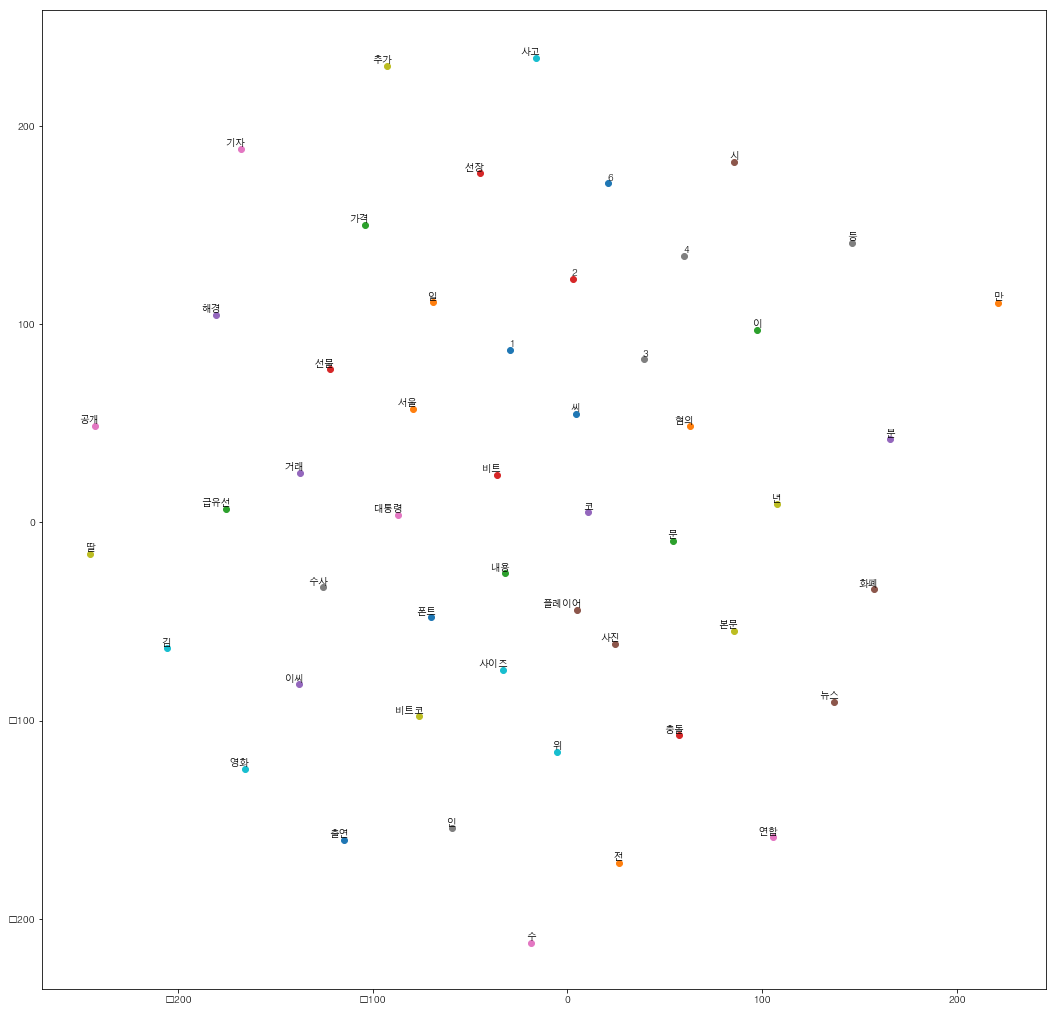

In [39]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 50
low_dim_embs = tsne.fit_transform(embedding_weights[:plot_only, :])  
labels = [labels[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

In [56]:
wordslist=['무단', '복제', '금지']

In [57]:
d2v_model.predict_output_word(context_words_list=wordslist) #다음 단어 예측

[('배포', 0.91249394),
 ('본문', 0.028782191),
 ('전재', 0.019379938),
 ('복제', 0.014417174),
 ('무단복제', 0.009943435),
 ('무단', 0.0090175476),
 ('내용', 0.003718676),
 ('금지', 0.0018052664),
 ('확인', 9.2902461e-05),
 ('쌍방', 4.232084e-05)]

In [42]:
d2v_model.docvecs #doc2vec의 벡터들 

In [44]:
d2v_model.docvecs.similarity('DOCU_0', 'DOCU_1') #문서간의 유사도 비교, 입력으로

0.78095774028791998

In [45]:
from scipy.spatial import distance

In [46]:
dst = distance.euclidean(d2v_model['영화'],d2v_model.docvecs['DOCU_0'])
print(dst) ##유클라디안 거리 계산

21.90923500061035


In [47]:
def searching(term, d2v): #단어와 각 문서간의 유클라디안 거리를 계산하는 함수
    d2v_dict = dict()
    for i in range(d2v.docvecs.count):
        d_key = 'DOCU_'+str(i)
        d2v_dict[d_key] = distance.euclidean(d2v[term],d2v.docvecs[i])
        #print(d_key+" : "+str(distance.euclidean(d2v[term],d2v.docvecs[i])))
    return d2v_dict

In [48]:
d2v_rank = searching('문재인',d2v_model) #각 문서와 단어간에 유클라디안을 계산하여 저장

In [49]:
for i in sorted(d2v_rank, key=lambda k : d2v_rank[k]): #기술에 대한 각 문서별 유클라디안 거리를 오름차순으로 정렬한 모습.
    print( i + " : " + str(d2v_rank[i]))

DOCU_5 : 18.267824172973633
DOCU_9 : 20.60468292236328
DOCU_0 : 20.735258102416992
DOCU_7 : 21.072288513183594
DOCU_3 : 23.68332862854004
DOCU_2 : 23.71521759033203
DOCU_1 : 24.24732780456543
DOCU_8 : 24.9720516204834
DOCU_4 : 25.030561447143555
DOCU_6 : 26.57111930847168


In [50]:
termlists[5]

['조원',
 '문',
 '문재인',
 '재인',
 '대통령',
 '문',
 '문재인씨',
 '재인',
 '씨',
 '호칭',
 '논란',
 '본문',
 '내용',
 '플레이어',
 '플레이어',
 '오류',
 '우회',
 '위',
 '함수',
 '추가',
 '머니',
 '머니투데이',
 '투데이',
 '신',
 '신현우',
 '현우',
 '기자',
 '조원',
 '애국',
 '대표',
 '조원',
 '애국',
 '문',
 '문재인',
 '재인',
 '대통령',
 '문',
 '문재인',
 '재인',
 '씨',
 '지칭',
 '논란',
 '일고',
 '조',
 '대표',
 '11',
 '11일',
 '일',
 '중앙',
 '중앙선거방송토론',
 '선거',
 '방송',
 '토론',
 '위원회',
 '개최',
 '정당',
 '정당정책토론회',
 '정책',
 '토론회',
 '문',
 '대통령',
 '현',
 '정부',
 '비판',
 '이',
 '과정',
 '문',
 '대통령',
 '문',
 '문재인',
 '재인',
 '씨',
 '반복',
 '지칭',
 '이',
 '자리',
 '그',
 '문',
 '문재인',
 '재인',
 '정부',
 '6',
 '6개월',
 '개월',
 '만',
 '안보',
 '한미',
 '한미동맹',
 '동맹',
 '경제',
 '파탄',
 '문',
 '문재인',
 '재인',
 '주장',
 '문',
 '문재인',
 '재인',
 '거짓',
 '촛불',
 '집회',
 '촛불',
 '촛불혁명',
 '혁명',
 '혁명',
 '말',
 '6',
 '6개월',
 '개월',
 '만',
 '이',
 '나라',
 '다',
 '한미',
 '한미동맹',
 '동맹',
 '다',
 '당시',
 '대통령',
 '호칭',
 '주의',
 '부탁',
 '조',
 '대표',
 '대통령',
 '대통령',
 '답변',
 '반면',
 '그',
 '박근',
 '박근혜',
 '혜',
 '전',
 '대통령',
 '지칭',
 '시',
 '대통령',
 '용어',
 '지금',
 '옆',
 '옆사람